In [ ]:
import numpy as np
from typing import Tuple

def simulate_var1(A: np.ndarray, n_samples: int, sigma: np.ndarray = None, 
                  y0: np.ndarray = None, seed: int = None) -> np.ndarray:
    """
    Simulate a VAR(1) model: Y_t = A Y_{t-1} + ε_t
    where ε_t ~ N(0, Sigma).
    """
    if seed is not None:
        np.random.seed(seed)
        
    if sigma is None:
        sigma = np.eye(2)
        
    if y0 is None:
        y0 = np.zeros(2)
    
    # Check dimensions
    assert A.shape == (2, 2), "A must be a 2x2 matrix"
    assert sigma.shape == (2, 2), "Sigma must be a 2x2 matrix"
    assert len(y0) == 2, "y0 must be a 2-dimensional vector"
    
    # Generate multivariate normal errors
    errors = np.random.multivariate_normal(np.zeros(2), sigma, size=n_samples)
    
    # Initialize the output array
    y_obs = np.zeros((n_samples, 2))
    y_obs[0] = y0
    
    # Generate the VAR(1) process
    for t in range(1, n_samples):
        y_obs[t] = A @ y_obs[t-1] + errors[t]
        
    return y_obs

def compute_s_statistics(y_obs: np.ndarray) -> Tuple[float, float, float]:
    """
    Compute the S:
    S_{n-1}^{(1)} = sum(y_i^{(1)}^2), S_{n-1}^{(2)} = sum(y_i^{(2)}^2), 
    S_{n-1}^{(1,2)} = sum(y_i^{(1)}*y_i^{(2)})
    """
    # Exclude the last observation for these statistics
    y = y_obs[:-1]
    
    s11 = np.sum(y[:, 0]**2)
    s22 = np.sum(y[:, 1]**2)
    s12 = np.sum(y[:, 0] * y[:, 1])
    
    return s11, s22, s12




def main():
    A_true = np.array([[0.5, 0.2], [0.1, 0.8]])
    Sigma_true = np.array([[1.0, 0.3], [0.3, 1.0]])
    
    # Simulate data
    n_samples = 10000
    y_obs = simulate_var1(A_true, n_samples, Sigma_true, seed=42)
    
    # Estimate A
    A_hat = estimate_A(y_obs)
    print("True A:")
    print(A_true)
    print("Estimated A (OLS):")
    print(A_hat)
    
    # Estimate Sigma_ε
    Sigma_hat = estimate_sigma_epsilon(y_obs, A_hat)
    print("True Sigma_ε:")
    print(Sigma_true)
    print("Estimated Sigma_ε:")
    print(Sigma_hat)
    
    

In [4]:
main()

True A:
[[0.5 0.2]
 [0.1 0.8]]
Estimated A (OLS):
[[0.48115726 0.20706848]
 [0.09085023 0.80432143]]
True Sigma_ε:
[[1.  0.3]
 [0.3 1. ]]
Estimated Sigma_ε:
[[1.00644963 0.31914227]
 [0.31914227 1.01293523]]


/tmp/ipykernel_9440/690901619.py:132: RuntimeWarning: invalid value encountered in scalar divide
  a11 = (h11 * s22 - h21 * s12) / D
/tmp/ipykernel_9440/690901619.py:133: RuntimeWarning: invalid value encountered in scalar divide
  a12 = (-h11 * s12 + h21 * s11) / D
/tmp/ipykernel_9440/690901619.py:134: RuntimeWarning: invalid value encountered in scalar divide
  a21 = (h12 * s22 - h22 * s12) / D
/tmp/ipykernel_9440/690901619.py:135: RuntimeWarning: invalid value encountered in scalar divide
  a22 = (-h12 * s12 + h22 * s11) / D


Estimated A (Martingale):
[[nan nan]
 [nan nan]]


In [ ]:
import numpy as np
from typing import Tuple, List, Dict
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from scipy.stats import norm

def predictive_resampling(y_obs: np.ndarray, n_future: int, n_bootstrap: int, 
                          seed: int = None) -> Dict:
    if seed is not None:
        np.random.seed(seed)
    
    m = len(y_obs)  # Number of observed points
    
    # Lists to store results
    A_samples = []
    Sigma_samples = []
    forecasts = np.zeros((n_bootstrap, n_future, 2))
    
    # For each bootstrap iteration
    for b in tqdm(range(n_bootstrap)):
        # Full path will contain observed data plus forecasted values
        full_path = np.zeros((m + n_future, 2))
        full_path[:m] = y_obs  # Start with observed data
        
        # Initial parameter estimates using observed data
        A_hat = estimate_A(y_obs)
        Sigma_hat = estimate_sigma_epsilon(y_obs, A_hat)
        
        # Generate future observations
        for t in range(m, m + n_future):
            # Get previous observation
            y_prev = full_path[t-1]
            # Forecast mean
            y_mean = A_hat @ y_prev
            # Generate random error
            epsilon = np.random.multivariate_normal(np.zeros(2), Sigma_hat)
            # store
            full_path[t] = y_mean + epsilon
            
            # Update forecasts array for plotting
            forecasts[b, t-m] = full_path[t]
            # Re-estimate parameters after each new observation
            if t < m + n_future - 1:  # No need to re-estimate for the last point
                A_hat = estimate_A(full_path[:t+1])
                Sigma_hat = estimate_sigma_epsilon(full_path[:t+1], A_hat)
        
        # Final parameter estimates using the complete path
        A_final = estimate_A(full_path)
        Sigma_final = estimate_sigma_epsilon(full_path, A_final)
        # Store the final estimates
        A_samples.append(A_final)
        Sigma_samples.append(Sigma_final)
    
    # Calculate statistics
    A_samples = np.array(A_samples)
    Sigma_samples = np.array(Sigma_samples)
    A_mean = np.mean(A_samples, axis=0)
    A_std = np.std(A_samples, axis=0)
    Sigma_mean = np.mean(Sigma_samples, axis=0)
    
    # Calculate 95% confidence intervals for each parameter
    A_quantiles = np.zeros((2, 2, 2))  # [param_i, param_j, [lower, upper]]
    Sigma_quantiles = np.zeros((2, 2, 2))  # [param_i, param_j, [lower, upper]]
    
    for i in range(2):
        for j in range(2):
            A_quantiles[i, j] = np.quantile(A_samples[:, i, j], [0.025, 0.975])
            Sigma_quantiles[i, j] = np.quantile(Sigma_samples[:, i, j], [0.025, 0.975])
    
    # Compile results
    results = {
        'A_samples': A_samples,
        'Sigma_samples': Sigma_samples,
        'forecasts': forecasts,
        'A_mean': A_mean,
        'A_std': A_std,
        'Sigma_mean': Sigma_mean,
        'A_quantiles': A_quantiles,
        'Sigma_quantiles': Sigma_quantiles
    }
    
    return results






In [ ]:
# Main
seed = 123
# Set a true A matrix
A_true = np.array([[0.5, 0.2], [0.1, 0.8]])

# Set error covariance matrix
Sigma_true = np.array([[1.0, 0.3], [0.3, 1.0]])

# Simulate observed data
n_obs = 100
y_obs = simulate_var1(A_true, n_obs, Sigma_true, seed=seed)

# Perform predictive resampling
n_resample = 1000  # Number of future time points to forecast
B = 200 

results = predictive_resampling(y_obs, n_resample, B, seed=seed)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


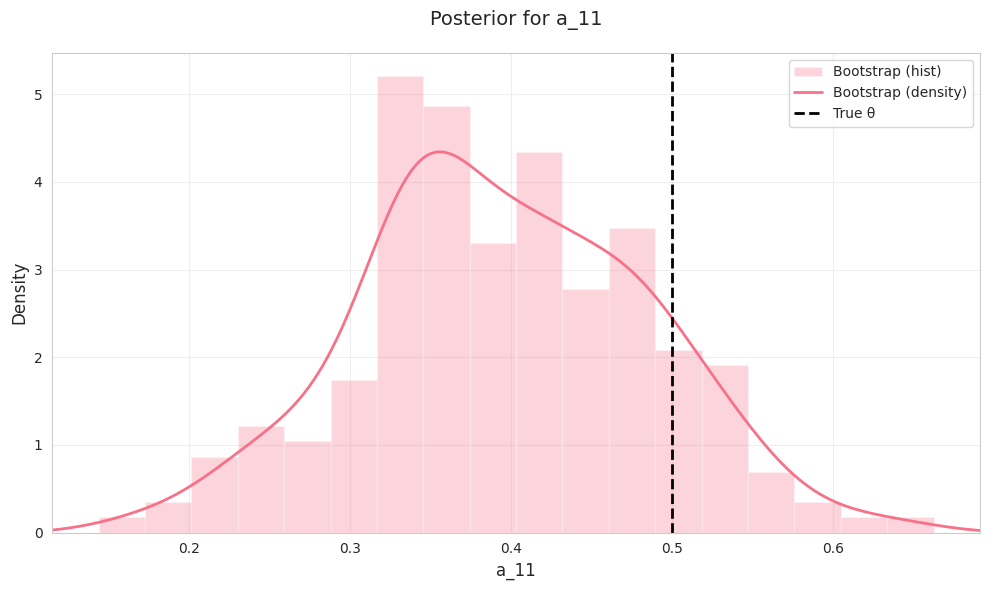

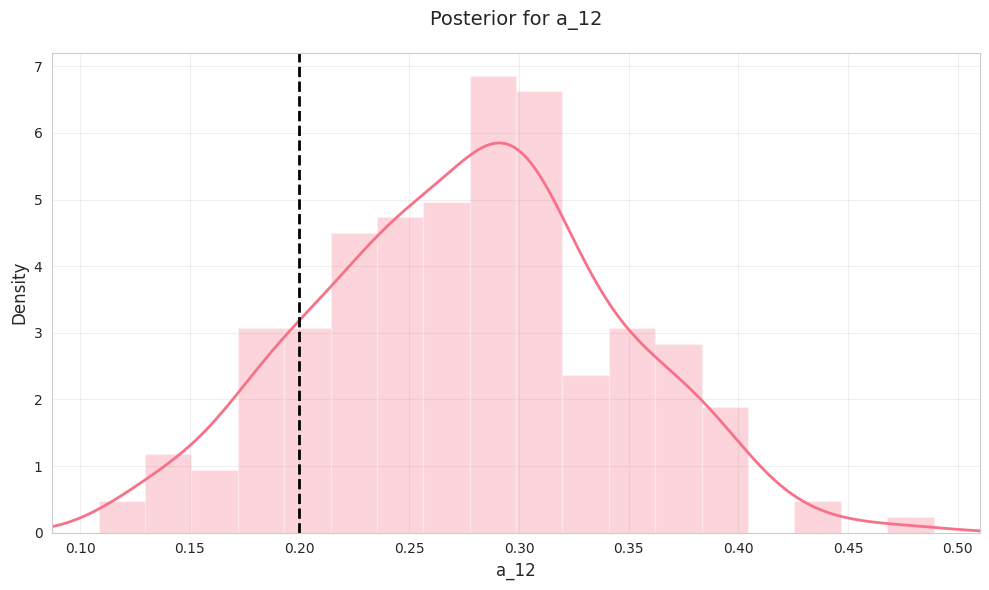

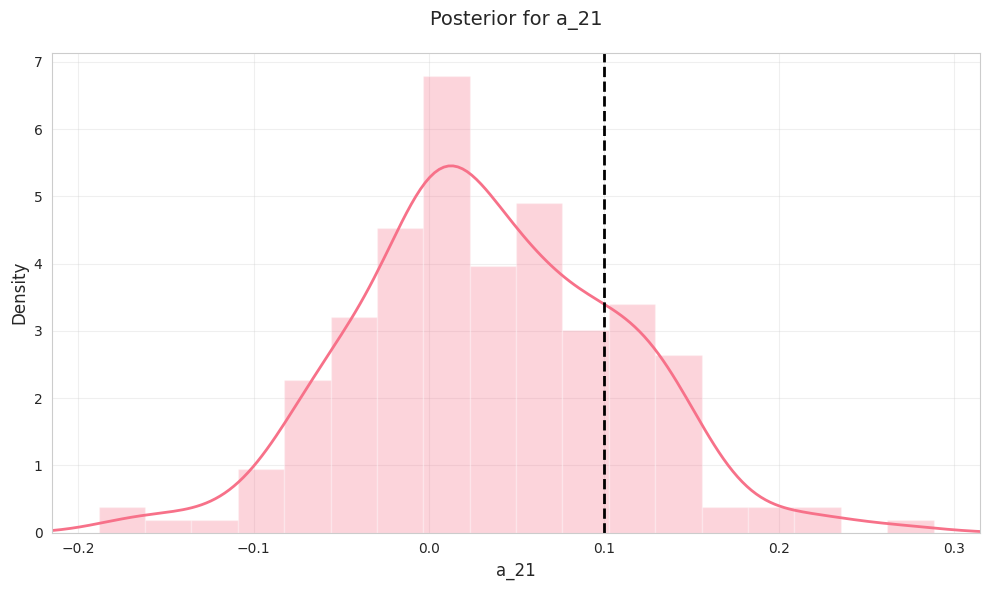

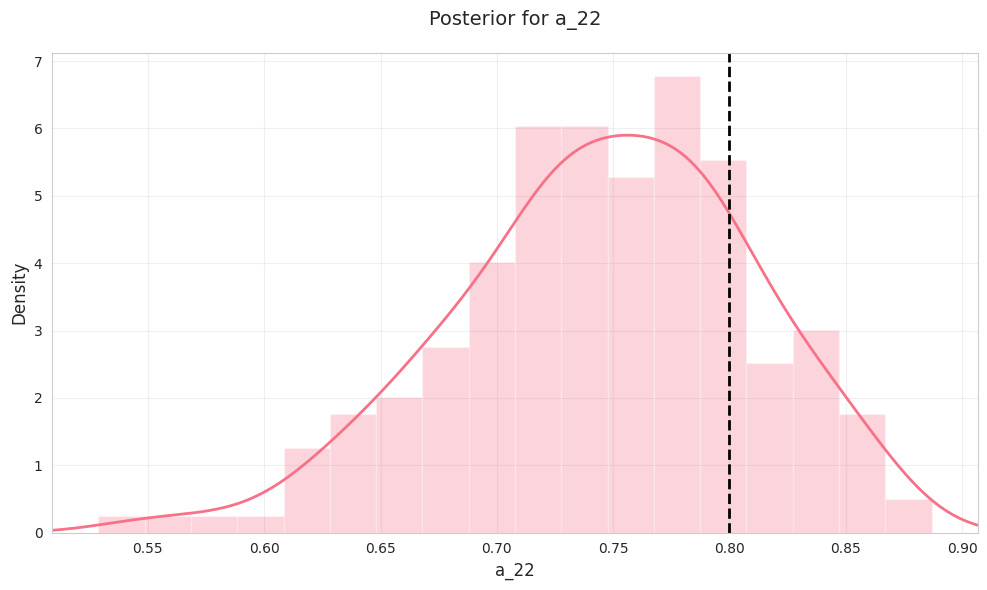

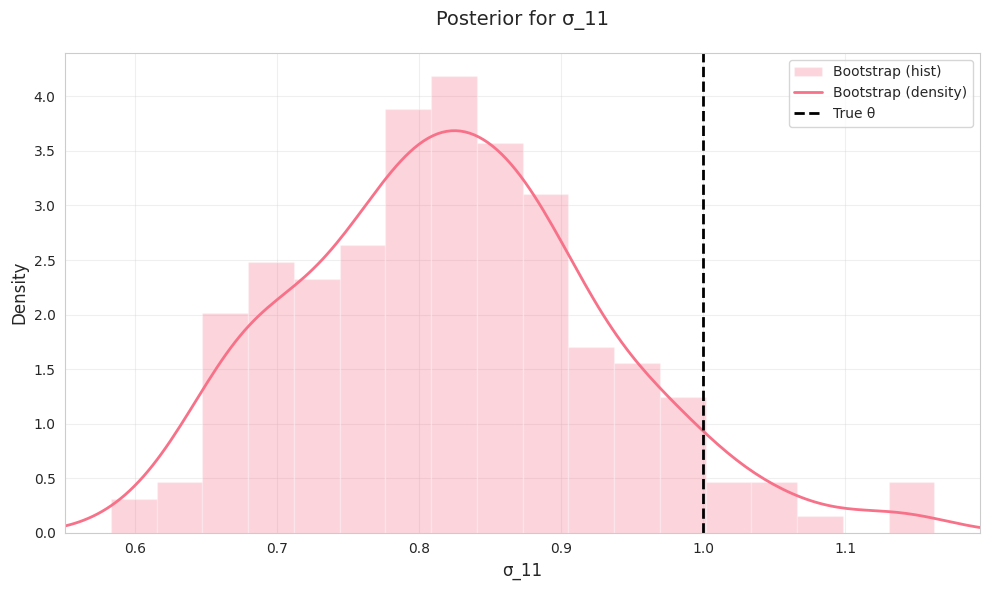

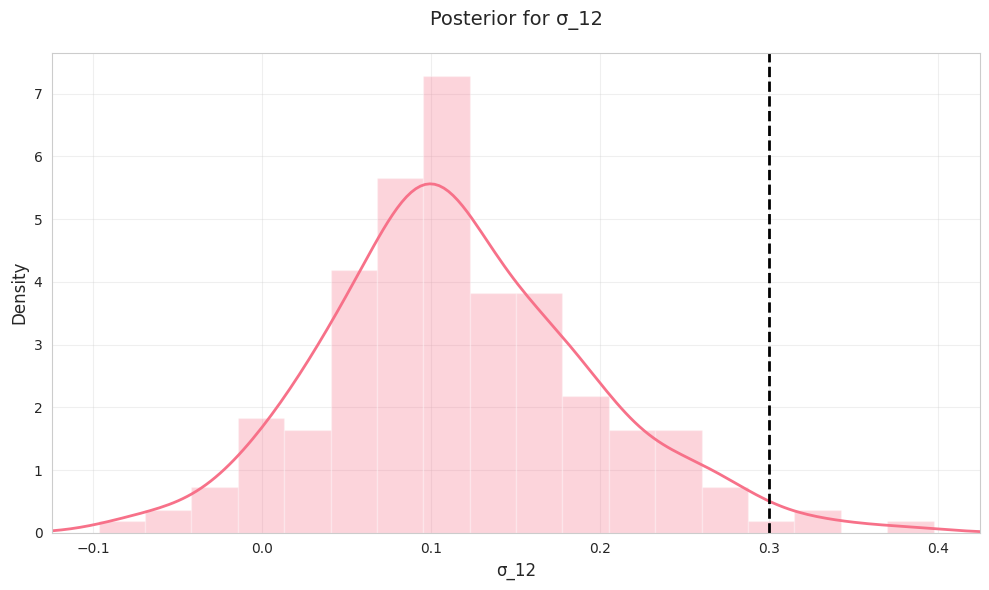

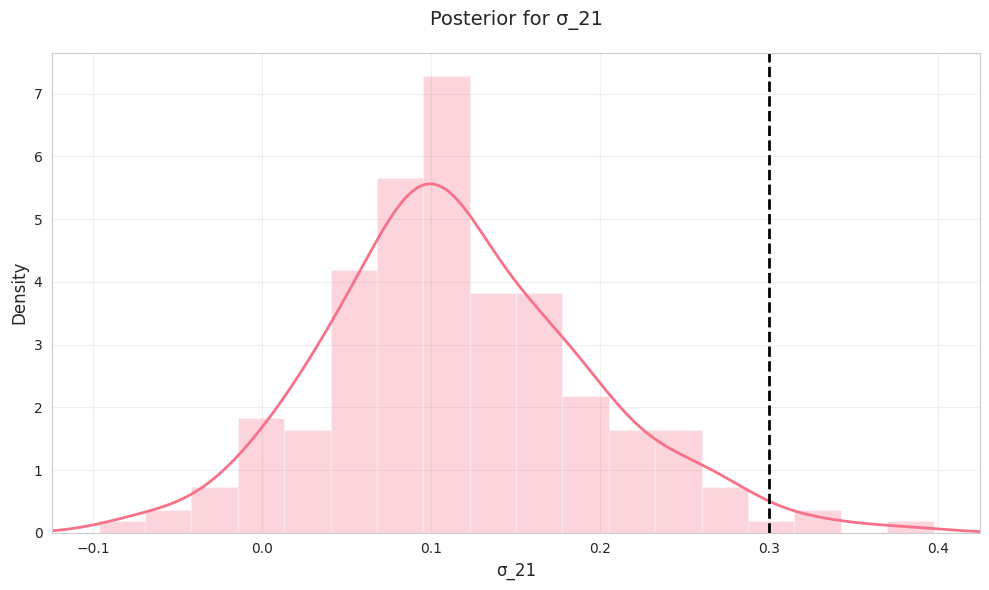

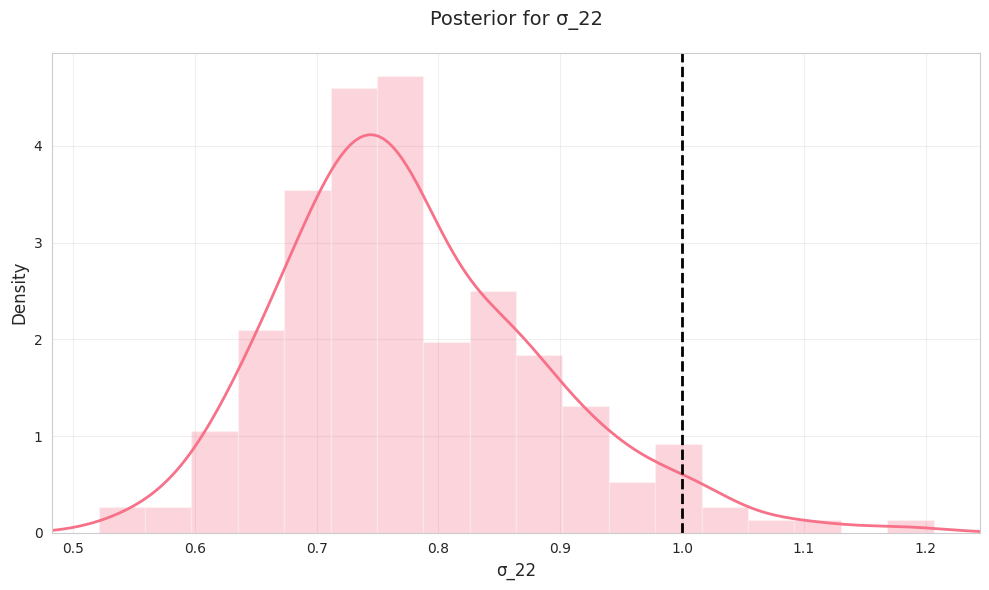

In [10]:
# Plot results
from src.plotting import plot_predictive_resampling_results, plot_var1_posteriors
# autoreload
%load_ext autoreload
%autoreload 2
    
# Plot posterior distributions
plot_var1_posteriors(
    results=results,
    true_A=A_true,
    true_Sigma=Sigma_true,
    bins=20,
    alpha=0.3
)